In [135]:
data = open('forth-coverage.dat', 'rb').read()
from struct import unpack
hits = unpack('65536I', data)


In [136]:
hits[0xf001]

13

In [137]:
hits[0xf100]

12

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns


In [139]:

import matplotlib.ticker as ticker

plt.style.use("dark_background")

def hexaxes(base=0):
    axes = plt.gca()
    xmax = max(*axes.get_xlim())
    ymax = max(*axes.get_ylim())
    dx, dy = 1, 1
    while xmax / dx > 10: 
        dx *= 2
    while ymax / dy > 10: 
        dy *= 2
    xax = axes.get_xaxis()
    yax = axes.get_yaxis()
    xax.set_major_locator(ticker.MultipleLocator(dx))
    yax.set_major_locator(ticker.MultipleLocator(dy))
    xax.set_major_formatter(ticker.FuncFormatter(lambda x, _: "0x%02x"%int(x)))
    yax.set_major_formatter(ticker.FuncFormatter(lambda y, _: "0x%04x"%int(y*xmax+base)))

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)


def heatmap_memory(memory, offset=0, size=None, shape=None, title=None):
    """memory should be a array with size a power of two"""
    
    if size is None:
        mem = memory[offset:]
        size = len(mem)
    else:
        mem = memory[offset:offset+size]

    if shape is None:
        x, y = 1, size
        while x < y:
            x <<= 1
            y >>= 1
        shape = (x,y)

    a = np.array(mem).reshape(shape)
    if a.max() > 0:
        sns.heatmap(a, cmap='flare_r', norm=LogNorm())
        hexaxes(offset)
    else:
        print("(empty)")

    if title:
        plt.title(title)


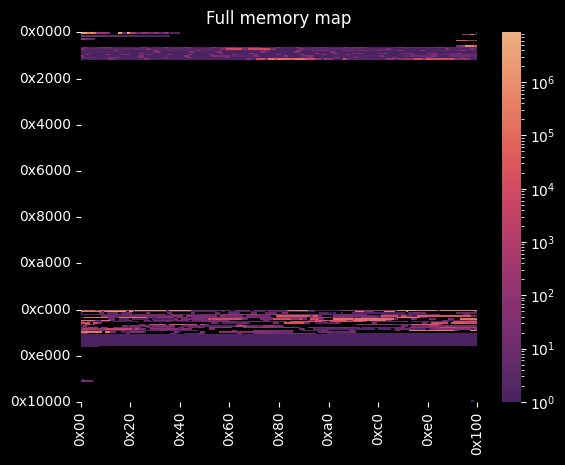

In [140]:
heatmap_memory(hits, title="Full memory map")

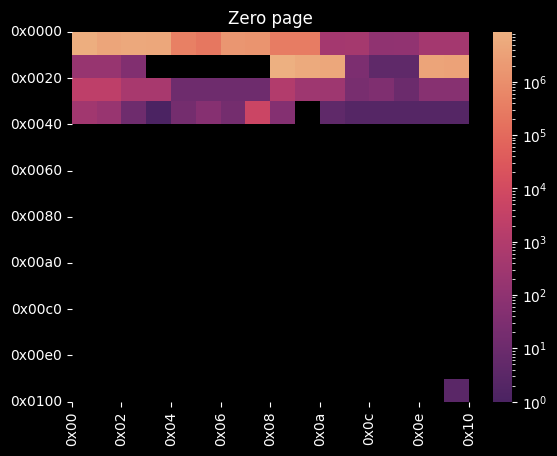

In [141]:
heatmap_memory(hits, size=0x100, title="Zero page")

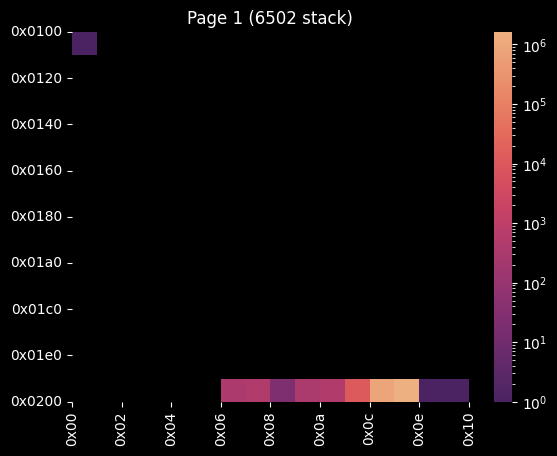

In [142]:
heatmap_memory(hits, offset=0x100, size=0x100, title="Page 1 (6502 stack)")

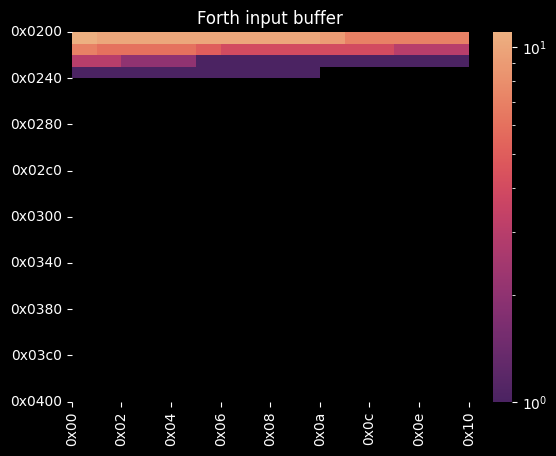

In [143]:
heatmap_memory(hits, offset=0x200, size=0x200, title="Forth input buffer")


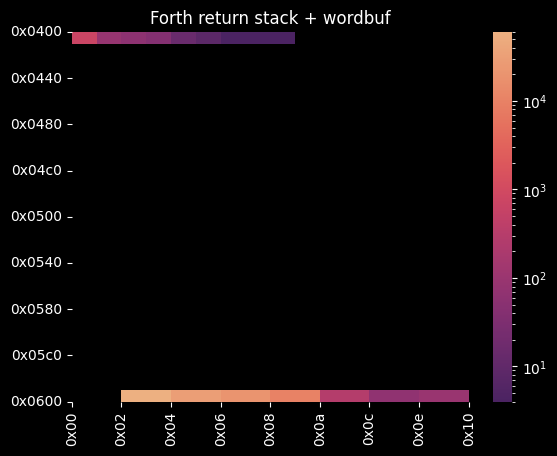

In [144]:
heatmap_memory(hits, offset=0x400, size=0x200, title="Forth return stack + wordbuf")


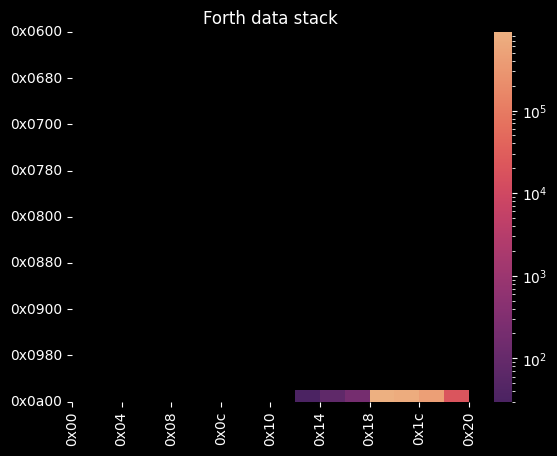

In [145]:
heatmap_memory(hits, offset=0x600, size=0x400, title="Forth data stack")


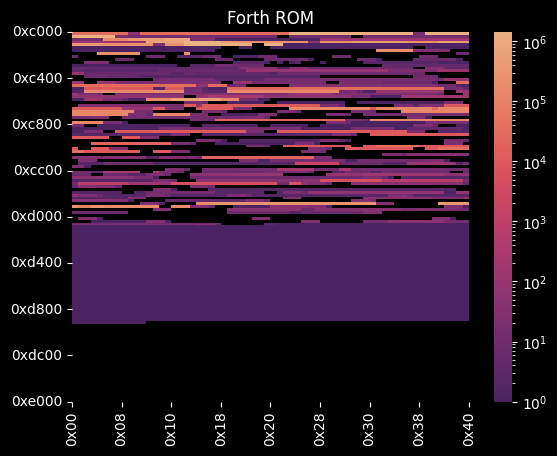

In [146]:
heatmap_memory(hits, offset=0xc000, size=0x2000, title="Forth ROM")


In [147]:
print(
    hits[0xc0da] / hits[0xc0d2],  # morepush
    hits[0xc0f9] / hits[0xc0d2],  # moreop
    hits[0xc0da],
    hits[0xc0f9],
    hits[0xc0d2],
)

0.157625527521895 0.15033877682987704 222310 212033 1410368


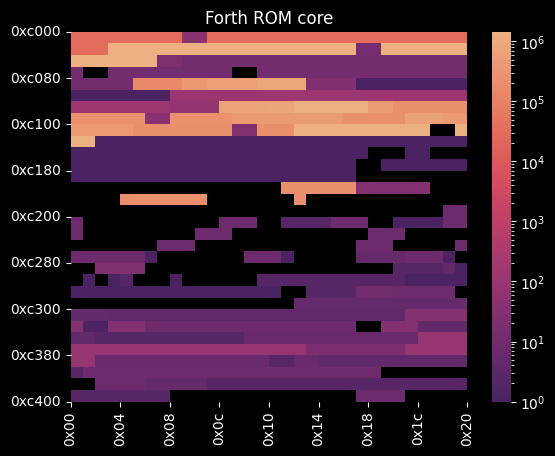

In [148]:
heatmap_memory(hits, offset=0xc000, size=0x400, title="Forth ROM core")

# 8 * $20 + $12 => $c112

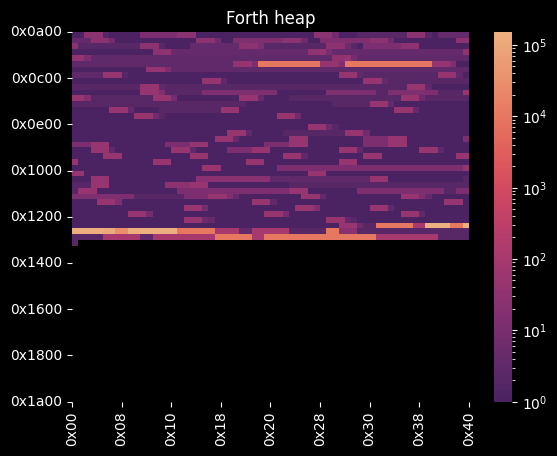

In [152]:
heatmap_memory(hits, offset=0xa00, size=0x1000, title="Forth heap")


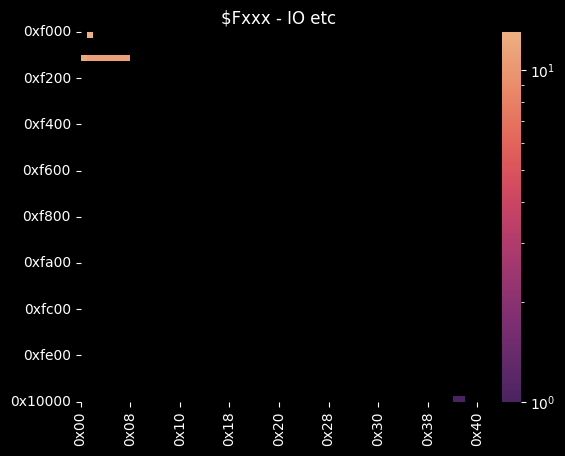

In [153]:
heatmap_memory(hits, offset=0xf000, size=0x1000, title="$Fxxx - IO etc")


In [155]:
rows = [line.split()[1:] for line in open('forth-test.mon').readlines() if line.startswith('al')]
symtab = []
symbols = {}
for (off, name) in rows:
    off = int(off, 16)
    symbols[name] = off
    symtab.append((hits[off], off, name))

symtab[:3]

[(7420113, 0, 'PC'),
 (7420113, 0, '__MAIN_FILEOFFS__'),
 (7420113, 0, '__MAIN_LAST__')]

In [156]:
# find is a hotspot while interpreting, e.g. when entering a number
# we need to loop thru 100+ words failing to find the number
# the length provides a simple hash but we still traverse the full linked list
# could improve by ~100x using 512 bytes to store separate latest x hash pointers

sorted([t for t in symtab if t[1] >= 0xa00], reverse=True)[:30]

[(1440531, 49220, 'nextword'),
 (1440531, 49187, '_NEXT'),
 (1410368, 49426, 'done'),
 (1410368, 49362, '_syncstack'),
 (873001, 49295, 'next0'),
 (730823, 49360, 'syncstack0'),
 (679461, 49356, 'syncstack1'),
 (636123, 49403, 'toreg'),
 (537343, 49291, 'nextp'),
 (444714, 49389, 'tostk'),
 (384745, 49289, 'next1'),
 (314923, 52987, 'ZBRANCH'),
 (285674, 52950, '_branch'),
 (222310, 49618, 'ok'),
 (222310, 49605, 'chkstkover'),
 (212033, 49604, 'ok'),
 (212033, 49585, 'chkstkunder'),
 (212033, 49413, 'shrnk'),
 (212033, 49401, 'morepop'),
 (162425, 52948, 'BRANCH'),
 (152598, 49285, 'next2'),
 (152538, 50636, '_2DUP'),
 (152422, 50434, 'DUP'),
 (152281, 50457, 'OVER'),
 (142291, 51120, 'MINUS'),
 (142280, 50933, '_cmp'),
 (142280, 50875, 'ispos'),
 (142280, 50872, 'chksgn'),
 (142280, 50865, 'not0'),
 (142280, 50851, '_cmp0')]

In [157]:
# unused

[t for t in symtab if t[0] == 0]

[(0, 20, 'XW'),
 (0, 22, 'YW'),
 (0, 15104, 'test_main'),
 (0, 15107, 'next'),
 (0, 15118, 'header'),
 (0, 15134, 'end'),
 (0, 15137, 'TST'),
 (0, 15139, 'test_pre'),
 (0, 15157, 'mul16'),
 (0, 15179, 'next'),
 (0, 15188, 'done'),
 (0, 15213, 'test_post'),
 (0, 15244, 'ok'),
 (0, 15253, 'test_cases'),
 (0, 15253, 'test_word16'),
 (0, 15269, 'test_A010'),
 (0, 15315, 'test_A020'),
 (0, 15347, 'test_A030'),
 (0, 15389, 'test_A040'),
 (0, 15429, 'test_A050'),
 (0, 15496, 'test_A060'),
 (0, 15554, 'test_A070'),
 (0, 15606, 'test_A080'),
 (0, 15666, 'test_A090'),
 (0, 15724, 'test_A0A0'),
 (0, 15767, 'test_A0B0'),
 (0, 15828, 'test_A0C0'),
 (0, 15868, 'test_A0D0'),
 (0, 15921, 'test_A0E0'),
 (0, 15973, 'test_A0F0'),
 (0, 16015, 'test_A100'),
 (0, 16068, 'test_A110'),
 (0, 16119, 'test_A120'),
 (0, 16178, 'test_A130'),
 (0, 16267, 'test_A140'),
 (0, 16374, 'test_A150'),
 (0, 16472, 'test_A160'),
 (0, 16507, 'test_A170'),
 (0, 16586, 'test_A180'),
 (0, 16637, 'test_A190'),
 (0, 16668, 'test_A

In [158]:
sorted([s for s in symtab if s[2].endswith('_header')])

[(8, 49662, 'VERSION_header'),
 (8, 49676, 'S0_header'),
 (8, 49685, 'R0_header'),
 (8, 49694, '_DOCOL_header'),
 (8, 49706, '_F_IMMED_header'),
 (8, 49720, '_F_HIDDEN_header'),
 (8, 49735, '_F_LENMASK_header'),
 (8, 49751, 'STATE_header'),
 (8, 49763, 'BASE_header'),
 (8, 49774, 'LATEST_header'),
 (8, 49787, 'HERE_header'),
 (8, 50295, 'EXIT_header'),
 (8, 50329, 'EXECUTE_header'),
 (8, 50363, 'DROP_header'),
 (9, 50386, 'SWAP_header'),
 (10, 50428, 'DUP_header'),
 (12, 50450, 'OVER_header'),
 (14, 50475, 'NIP_header'),
 (15, 50497, 'ROT_header'),
 (15, 50552, 'NROT_header'),
 (15, 50605, '_2DROP_header'),
 (16, 50629, '_2DUP_header'),
 (17, 50651, '_2SWAP_header'),
 (17, 50706, 'QDUP_header'),
 (17, 50748, 'ZEQU_header'),
 (17, 50792, 'ZNEQU_header'),
 (17, 50804, 'EQU_header'),
 (17, 50831, 'NEQU_header'),
 (17, 50842, 'ZLT_header'),
 (17, 50890, 'ZGT_header'),
 (17, 50901, 'ZLE_header'),
 (17, 50913, 'ZGE_header'),
 (17, 50925, 'LT_header'),
 (17, 50953, 'GT_header'),
 (18, 50963, 

In [159]:
[t for t in symtab if t[2].startswith('FIND')]

[(21, 52429, 'FIND_header'), (47, 52436, 'FIND')]

In [160]:
data = open('forth-writes.dat', 'rb').read()
from struct import unpack
writes = unpack('65536I', data)
sorted(enumerate(writes), key=lambda xy: -xy[1])[:10]

[(24, 2851054),
 (26, 2820712),
 (0, 1988612),
 (30, 1919135),
 (31, 1756355),
 (25, 1440686),
 (509, 808597),
 (7, 754890),
 (6, 754821),
 (2, 464820)]

In [161]:
symbols['DOCOL'], symbols['__HEAP_START__']

(49152, 2560)

In [162]:
# no ROM writes (_tgtword TODO)
for i in range(symbols['DOCOL'], 0xf000):
    if writes[i]: print(f"{i:04x}", writes[i])

c047 11
c048 11


In [163]:
for v in 'DOCOL STATE LATEST HERE __HEAP_START__'.split():
    if v+'_value' in symbols:
        v += '_value'
    print(v, "{:04x}".format(symbols[v]))

DOCOL c000
STATE_value c261
LATEST_value c279
HERE_value c284
__HEAP_START__ 0a00
